In [1]:
import argparse
import datetime
import hashlib
import os
import shutil
import sys

import argparse
import logging
import time
from os.path import exists

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from StockPredictorHMM import StockRegressorHMM


np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [19]:
df = pd.read_csv('../../stock/AAPL.csv', parse_dates=True, index_col='Date')
X_train, X_test = train_test_split(df, test_size=0.03, shuffle=False)

In [3]:
X_train.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-03 00:00:00-04:00,138.210007,143.070007,137.690002,142.449997,142.214081,114311700
2022-10-04 00:00:00-04:00,145.029999,146.220001,144.259995,146.100006,145.858047,87830100
2022-10-05 00:00:00-04:00,144.070007,147.380005,143.009995,146.399994,146.157532,79471000
2022-10-06 00:00:00-04:00,145.809998,147.539993,145.220001,145.429993,145.189148,68402200
2022-10-07 00:00:00-04:00,142.539993,143.100006,139.449997,140.089996,139.857986,85925600


In [5]:
predictor = StockRegressorHMM()
predictor.fit(df)

In [6]:
# predictor.predict(X_test, plot=True)

In [7]:
# 142.539993 143.100006	139.449997	140.089996	139.857986	85925600

In [8]:
today = pd.DataFrame({
                    "Date": X_train.index[0],
                    "Open": [142.53],
                    "High": [143.10],
                    "Low": [139.44],
                    "Close": [140.08],
                    "Volume": [85925600]
}).set_index('Date')

In [9]:
today

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03 00:00:00-05:00,142.53,143.1,139.44,140.08,85925600


In [10]:
predictor.predict(today)

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


array([ 142.821,  143.392,  139.725,  140.366,  86100958.360])

In [11]:
y_pred = np.array([])
epoch = len(X_test)
for i in range(epoch):
    pred = predictor.predict(today)
    y_pred = np.append(y_pred, pred[3])
    today['Open'] = pred[0]
    today['High'] = pred[1]
    today['Low'] = pred[2]
    today['Close'] = pred[3]
    today['Volume'] = pred[4]
    

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


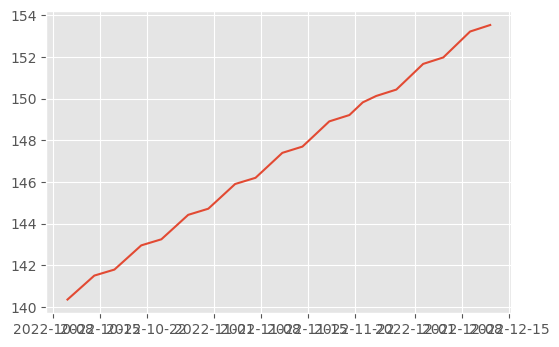

In [23]:
days = np.array(X_test.index, dtype="datetime64[ms]")
y_pred
y_test = X_test['Close']

plt.plot(days, y_pred)

In [ ]:
days = np.array(X_test.index, dtype="datetime64[ms]")
actual_close_prices = X_test['Close']
 
fig = plt.figure()
 
axes = fig.add_subplot(111)
axes.plot(days, actual_close_prices, 'bo-', label="actual")
axes.plot(days, predicted_close_prices, 'r+-', label="predicted")
 
fig.autofmt_xdate()
 
plt.legend()
plt.show()